# Waymo Motion Detection - Tutorial 2

시각화 해보자

### INDEX

1. [MapFeature 시각화](#1.-MapFeature-시각화)
2. [DynamicMapState 시각화](#2.-DynamicMapState-시각화)


-----

In [230]:
import os
import tensorflow as tf
from waymo_open_dataset.protos import scenario_pb2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.core.display import display, HTML # Jupyter에서 출력하기 위한 용도

dataset_dir = "../../../dataset/waymo-dataset/validation/"

dataset_fnames = os.listdir(dataset_dir)
dataset_paths  = sorted([os.path.join(dataset_dir, fname) for fname in dataset_fnames])

dataset = tf.data.TFRecordDataset(dataset_paths[0])
dataset

/tmp/ipykernel_4042/2445477528.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML # Jupyter에서 출력하기 위한 용도


<TFRecordDatasetV2 shapes: (), types: tf.string>

In [231]:
for data in dataset:
    proto_string = data.numpy()
    scenario = scenario_pb2.Scenario()
    scenario.ParseFromString(proto_string)
    break

---

# 1. MapFeature 시각화
map 데이터를 출력해본다. 차선, 표지판, 방지턱, 횡단보도 등 다양한 데이터가 존재한다. 우선 하나의 시나리오에 존재하는 첫 번째 map feature를 출력해보자

In [141]:
def poly2postion(poly, is_polygon=False):
    # MapPoint[]
    x, y, z = [], [], []
    for point in poly:
        x.append(point.x)
        y.append(point.y)
        z.append(point.z)
        
    if is_polygon:
        # 도형일 경우 마감 처리를 해주어야 함.
        x.append(x[0])
        y.append(y[0])
        z.append(z[0])
    return x, y, z

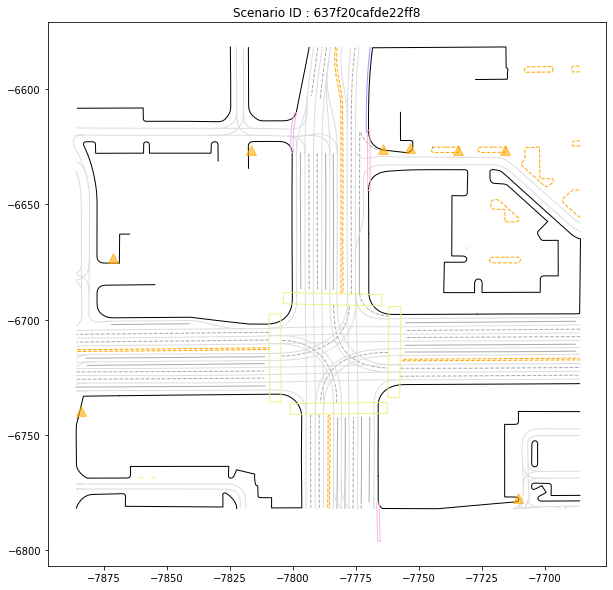

In [197]:
fig, ax = plt.subplots(figsize=(10,10))
ax.title.set_text("Scenario ID : " + scenario.scenario_id)

def visualize_static_map_feature(feature):
    # feature: MapFeature
    # TODO 각 옵션 이해가 안되는게 좀 있어서 더 자세하게 알아봐야 함.

    # LaneCenter lane (차로 중간선)
    if feature.lane != None:
        lane_x, lane_y, lane_z = poly2postion(feature.lane.polyline)
        if feature.lane.type == 1: # TYPE_FREEWAY (?)
            ax.plot(lane_x, lane_y, '-', c='#f006', lw=3) # 연한 빨강
        elif feature.lane.type == 2: # TYPE_SURFACE_STREET (노면 도로)
            ax.plot(lane_x, lane_y, '-', c='#ddd', lw=1) # 연한 회색
        elif feature.lane.type == 3: # TYPE_BIKE_LANE (자전거 도로)
            ax.plot(lane_x, lane_y, '-', c='#00f6', lw=1) # 연한 파란색

    # RoadLine road_line (차선)
    if feature.road_line != None:
        road_line_x, road_line_y, road_line_z = poly2postion(feature.road_line.polyline)
        if feature.road_line.type == 1: # TYPE_BROKEN_SINGLE_WHITE
            ax.plot(road_line_x, road_line_y, '--', c='#aaa', lw=1)
        elif feature.road_line.type == 2: # TYPE_SOLID_SINGLE_WHITE
            ax.plot(road_line_x, road_line_y, '-', c='#aaa', lw=1)
        elif feature.road_line.type == 3: # TYPE_SOLID_DOUBLE_WHITE
            ax.plot(road_line_x, road_line_y, '-', c='#aaa', lw=1)
        elif feature.road_line.type == 4: # TYPE_BROKEN_SINGLE_YELLOW
            ax.plot(road_line_x, road_line_y, '--', c='#f1f289', lw=1)
        elif feature.road_line.type == 5: # TYPE_BROKEN_DOUBLE_YELLOW
            ax.plot(road_line_x, road_line_y, '--', c='#f1f289', lw=1)
        elif feature.road_line.type == 6: # TYPE_SOLID_SINGLE_YELLOW
            ax.plot(road_line_x, road_line_y, '-', c='#f1f289', lw=1)
        elif feature.road_line.type == 7: # TYPE_SOLID_DOUBLE_YELLOW
            ax.plot(road_line_x, road_line_y, '-', c='#f1f289', lw=1)
        elif feature.road_line.type == 8: # TYPE_PASSING_DOUBLE_YELLOW
            ax.plot(road_line_x, road_line_y, '--', c='#f1f289', lw=1)

    # RoadEdge road_edge
    if feature.road_edge != None:
        road_edge_x, road_edge_y, road_edge_z = poly2postion(feature.road_edge.polyline)
        if feature.road_edge.type == 1: # TYPE_ROAD_EDGE_BOUNDARY
            ax.plot(road_edge_x, road_edge_y, '-', c='black', lw=1)
        elif feature.road_edge.type == 2: # TYPE_ROAD_EDGE_MEDIAN
            ax.plot(road_edge_x, road_edge_y, '--', c='orange', lw=1)

    # StopSign stop_sign (정지표시)
    if feature.stop_sign != None:
        point = feature.stop_sign.position
        if point.x != 0 or point.y != 0 or point.z != 0:
            ax.plot(point.x, point.y, marker='^', c='#fa09', ms=10)

    # Crosswalk crosswalk (횡단보도)
    if feature.crosswalk != None and len(feature.crosswalk.polygon) > 0:
        crosswalk_x, crosswalk_y, crosswalk_z = poly2postion(feature.crosswalk.polygon, True)
        ax.plot(crosswalk_x, crosswalk_y, '-', c='#f1f289', lw=1) # 노란색

    # SpeedBump speed_bump (방지턱)
    if feature.speed_bump != None and len(feature.speed_bump.polygon) > 0:
        speed_bump_x, speed_bump_y, speed_bump_z = poly2postion(feature.speed_bump.polygon, True)
        ax.plot(speed_bump_x, speed_bump_y, '-' , c='#fab6e6', lw=1) # 핑크색

for feature in scenario.map_features:
    visualize_static_map_feature(feature)

## 2. DynamicMapState 시각화
`repeated DynamicMapState` 형태의 `dynamic_map_states` 데이터를 시각화해보자. 본 객체는 동적 상태를 포함하며, 실제로 신호등 데이터가 들어가있다.

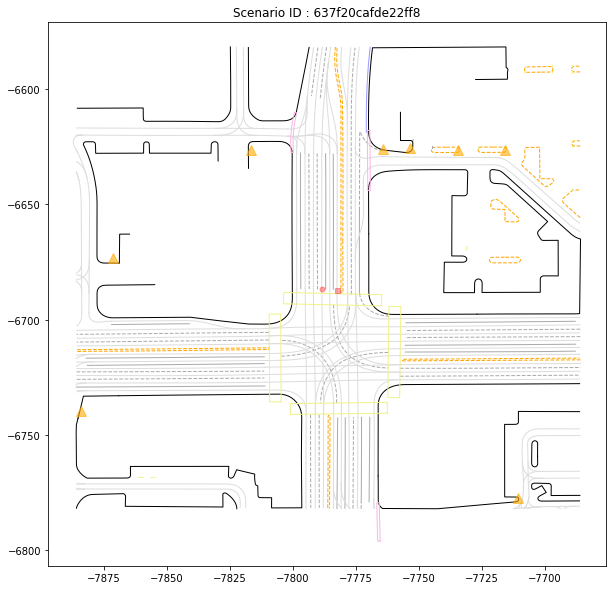

In [221]:
fig, ax = plt.subplots(figsize=(10,10))
ax.title.set_text("Scenario ID : " + scenario.scenario_id)

class DynamicMapStateVisualizer():
    def __init__(self, scenario, ax):
        self.scenario = scenario
        self.lane_state_arrow_stop,       = ax.plot([], [], marker='s', c='#f005', ms=5)
        self.lane_state_arrow_caution,    = ax.plot([], [], marker='s', c='#fa05', ms=5)
        self.lane_state_arrow_go,         = ax.plot([], [], marker='s', c='#0f05', ms=5)
        self.lane_state_stop,             = ax.plot([], [], marker='o', c='#f005', ms=5)
        self.lane_state_caution,          = ax.plot([], [], marker='o', c='#fa05', ms=5)
        self.lane_state_go,               = ax.plot([], [], marker='o', c='#0f05', ms=5)
        self.lane_state_flashing_stop,    = ax.plot([], [], marker='*', c='#f005', ms=5)
        self.lane_state_flashing_caution, = ax.plot([], [], marker='*', c='#fa05', ms=5)

    def update(self, idx):
        # map_state : DynamicMapState
        map_state = self.scenario.dynamic_map_states[idx]
        for lane_state in map_state.lane_states:
            # lane_state : TrafficSignalLaneState
            point = lane_state.stop_point
            if lane_state.state == 1: # LANE_STATE_ARROW_STOP
                self.lane_state_arrow_stop.set_data(point.x, point.y)
            elif lane_state.state == 2: # LANE_STATE_ARROW_CAUTION
                self.lane_state_arrow_caution.set_data(point.x, point.y)
            elif lane_state.state == 3: # LANE_STATE_ARROW_GO 
                self.lane_state_arrow_go.set_data(point.x, point.y)
            elif lane_state.state == 4: # LANE_STATE_STOP 
                self.lane_state_stop.set_data(point.x, point.y)
            elif lane_state.state == 5: # LANE_STATE_CAUTION 
                self.lane_state_caution.set_data(point.x, point.y)
            elif lane_state.state == 6: # LANE_STATE_GO
                self.lane_state_go.set_data(point.x, point.y)
            elif lane_state.state == 7: # LANE_STATE_FLASHING_STOP 
                self.lane_state_flashing_stop.set_data(point.x, point.y)
            elif lane_state.state == 8: # LANE_STATE_FLASHING_CAUTION 
                self.lane_state_flashing_caution.set_data(point.x, point.y)

for feature in scenario.map_features:
    visualize_static_map_feature(feature)

viz = DynamicMapStateVisualizer(scenario, ax)
viz.update(0)


## 3. Track 시각화
> 진행중. objects_of_interest 검증 로직 없애고, 순수 agent type으로만 나누어 시각화를 진행하고, 그 다음에 objects_of_interest 검증을 통해 추가 표시를 하는 방식으로 수정 예정  

`Track` 객체를 시각화한다. 본 객체에는 각 Agent의 상태 정보가 들어가있다.

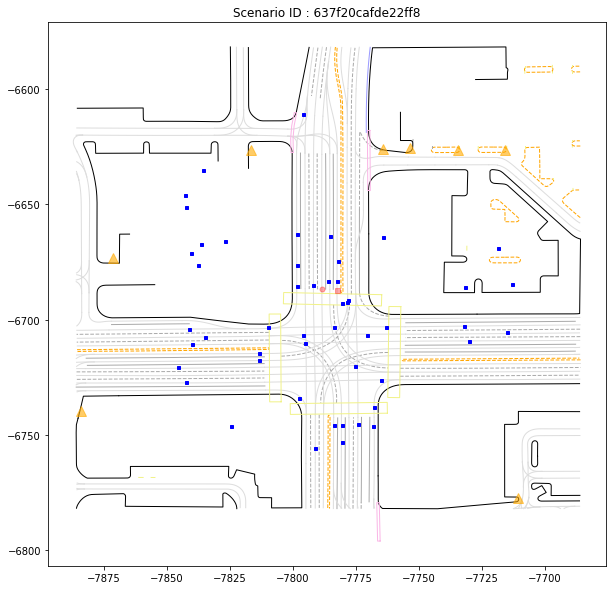

In [227]:
fig, ax = plt.subplots(figsize=(10,10))
ax.title.set_text("Scenario ID : " + scenario.scenario_id)

class TrackVisualizer:
    def __init__(self, scenario, ax):
        self.scenario = scenario
        self.normal_objects,  = ax.plot([], [], 's', c='blue', ms=3)
        self.mission_objects, = ax.plot([], [], 's', c='red',  ms=3)
    
    def update(self, idx):
        mission_x, mission_y, mission_z = [], [], []
        state_x, state_y, state_z       = [], [], []

        for track in self.scenario.tracks:
            state = track.states[idx]
            if state.valid:
                if track.id in self.scenario.objects_of_interest:
                    # 예측해야하는 객체
                    mission_x.append(state.center_x)
                    mission_y.append(state.center_y)
                    mission_z.append(state.center_z)
                else:
                    # 일반 객체
                    state_x.append(state.center_x)
                    state_y.append(state.center_y)
                    state_z.append(state.center_z)
            else:
                pass #print("ERROR :: Invalid track state")

        self.normal_objects.set_data(state_x, state_y)
        self.mission_objects.set_data(mission_x, mission_y)


for feature in scenario.map_features:
    visualize_static_map_feature(feature)

viz_1 = DynamicMapStateVisualizer(scenario, ax)
viz_1.update(0)

viz_2 = TrackVisualizer(scenario, ax)
viz_2.update(0)

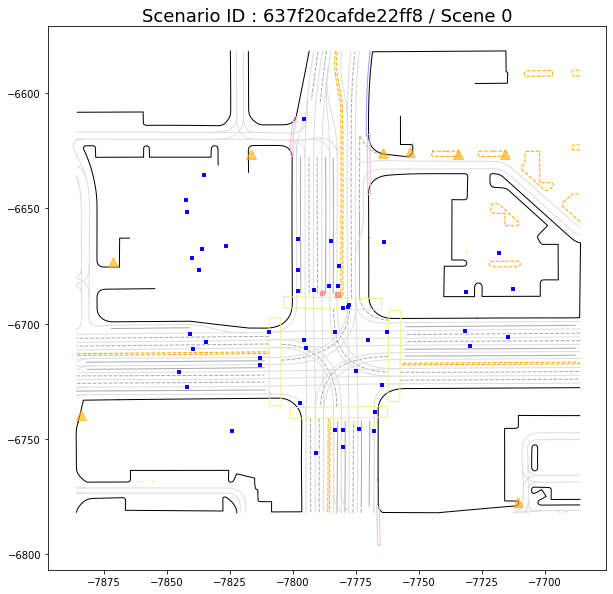

In [236]:
fig, ax = plt.subplots(figsize=(10,10))
ax.title.set_text("Scenario ID : " + scenario.scenario_id)

for feature in scenario.map_features:
    visualize_static_map_feature(feature)

viz_1 = DynamicMapStateVisualizer(scenario, ax)
viz_2 = TrackVisualizer(scenario, ax)

def updateFrame(idx):
    ax.set_title("Scenario ID : " + scenario.scenario_id + " / Scene " + str(idx), fontsize=18)
    viz_1.update(idx)
    viz_2.update(idx)

animation = FuncAnimation(fig, updateFrame, frames=range(len(scenario.timestamps_seconds)))
video_tag = HTML(animation.to_html5_video())
#display(video_tag) # 영상 출력 부분

모든 객체를 시간의 흐름에 따라 출력했다. 예측해야하는 객체를 명확하게 표현하면 더 좋을 것 예측할 객체가 존재하는 `6bdceecbf2416202 시나리오`를 시각화 하도록 아래와 같이 수정했다.

In [237]:
for data_no, data in enumerate(dataset):
    proto_string = data.numpy()
    scenario = scenario_pb2.Scenario()
    scenario.ParseFromString(proto_string)
    
    if len(scenario.objects_of_interest) == 0:
        # 예측해야 할 객체가 없는 시나리오는 그냥 패스
        continue
    else:
        break

scenario.scenario_id

'6bdceecbf2416202'

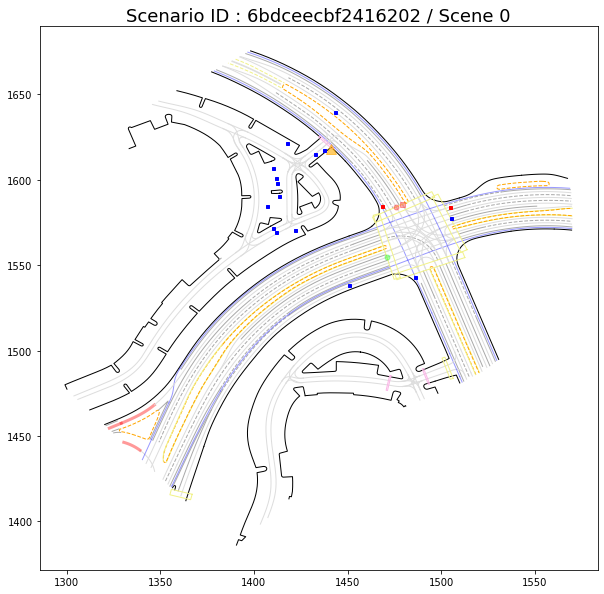

In [239]:
fig, ax = plt.subplots(figsize=(10,10))
ax.title.set_text("Scenario ID : " + scenario.scenario_id)

for feature in scenario.map_features:
    visualize_static_map_feature(feature)

viz_1 = DynamicMapStateVisualizer(scenario, ax)
viz_2 = TrackVisualizer(scenario, ax)

def updateFrame(idx):
    ax.set_title("Scenario ID : " + scenario.scenario_id + " / Scene " + str(idx), fontsize=18)
    viz_1.update(idx)
    viz_2.update(idx)

animation = FuncAnimation(fig, updateFrame, frames=range(len(scenario.timestamps_seconds)))
video_tag = HTML(animation.to_html5_video())
display(video_tag) # 영상 출력 부분